In [2]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from pathlib import Path



In [3]:
DATA_PATH = Path("data_final") / "btcusdt_1m_20240511‑20250511.parquet"
df = pd.read_parquet(DATA_PATH)

# EMA indicator

max|Δ| = 0.0


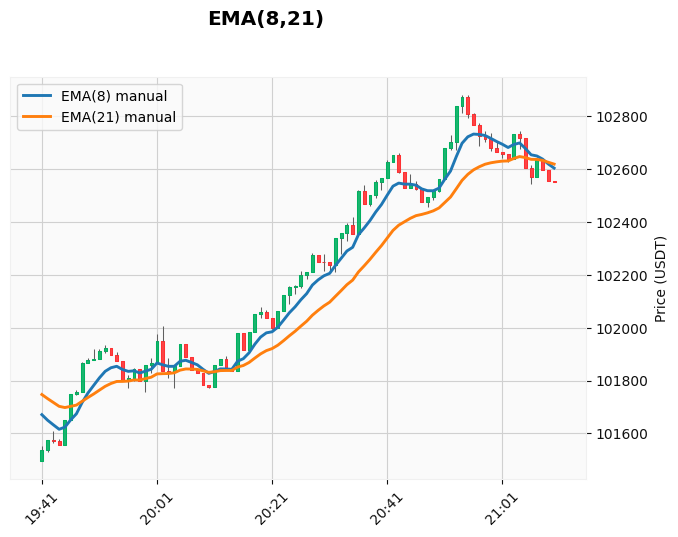

In [4]:
def ema_indk(prices: np.ndarray, span: int) -> np.ndarray:
    alpha = 2.0 / (span + 1)
    ema = np.empty_like(prices, dtype=float)
    ema[0] = prices[0]
    for i in range(1, len(prices)):
        ema[i] = alpha * prices[i] + (1 - alpha) * ema[i-1]
    return ema

prices = df['Close'].values
df['EMA_8_manual']  = ema_indk(prices, span=8)
df['EMA_21_manual'] = ema_indk(prices, span=21)

subset = df.iloc[-90:].copy()
ema8_plot  = mpf.make_addplot(subset['EMA_8_manual'], label='EMA(8) manual')
ema21_plot = mpf.make_addplot(subset['EMA_21_manual'],   label='EMA(21) manual')

fig, axlist = mpf.plot(
    subset,
    type='candle',
    addplot=[ema8_plot, ema21_plot],
    title='EMA(8,21)',
    style='yahoo',
    ylabel='Price (USDT)',
    datetime_format='%H:%M',
    returnfig=True
)

axlist[0].legend(loc='best')

ema_pd = df['Close'].ewm(span=8, adjust=False).mean().values
ema_np = ema_indk(df['Close'].values, 8)
print("max|Δ| =", np.abs(ema_pd - ema_np).max())


# RSI indicator

max|Δ| vs. reference method: 0


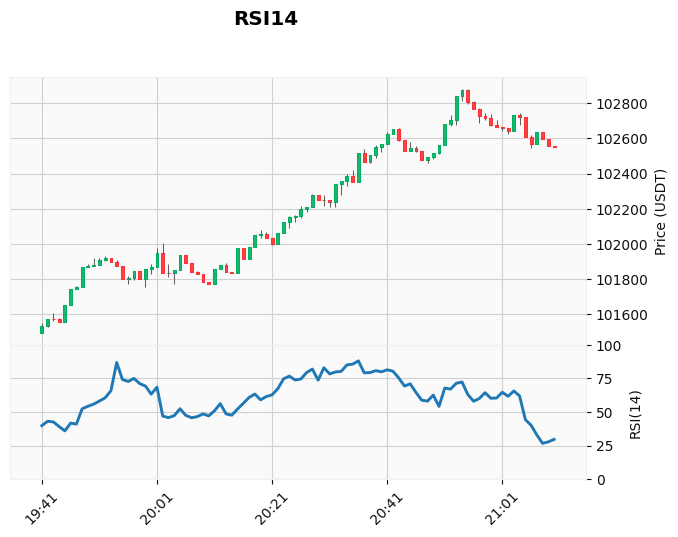

In [5]:
def rsi_indk(prices: np.ndarray, window: int = 14) -> np.ndarray:
    delta = np.diff(prices, prepend=prices[0])
    gain  = np.where(delta > 0,  delta, 0.0)
    loss  = np.where(delta < 0, -delta, 0.0)

    roll_up   = pd.Series(gain).rolling(window).mean()
    roll_down = pd.Series(loss).rolling(window).mean()
    rs  = roll_up / roll_down
    rsi = 100 - 100 / (1 + rs)
    return rsi.to_numpy()

df['RSI_14'] = rsi_indk(df['Close'].values, 14)

rsi_pd = 100 - 100 / (1 + (
    df['Close'].diff().clip(lower=0).rolling(14).mean() /
    (-df['Close'].diff().clip(upper=0)).rolling(14).mean()
))
max_err = np.abs(df['RSI_14'] - rsi_pd).dropna().max()
print(f"max|Δ| vs. reference method: {max_err:.3g}")

subset = df.iloc[-90:].copy()
rsi_plot = mpf.make_addplot(subset['RSI_14'],
                            panel=1, ylabel='RSI(14)',
                            ylim=(0,100), secondary_y=False)

mpf.plot(
    subset,
    type='candle',
    addplot=[rsi_plot],
    panel_ratios=(2,1),
    title='RSI14',
    style='yahoo',
    ylabel='Price (USDT)',
    datetime_format='%H:%M'
)

Stoch_%K_fast: min=0.00, max=100.00
Stoch_%D_slow: min=0.00, max=100.00


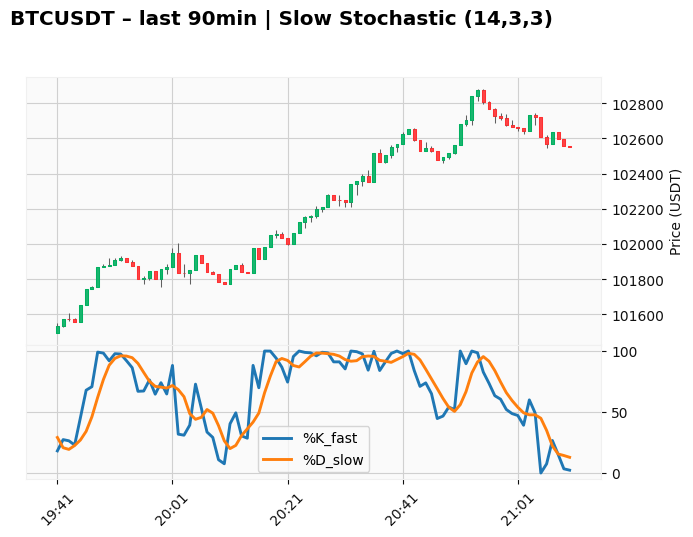

In [6]:
def stochastic_osc(high: pd.Series,
                   low: pd.Series,
                   close: pd.Series,
                   k_period: int = 14,
                   d_period: int = 3,
                   dd_period: int = 3):

    lowest_low   = low.rolling(k_period, min_periods=1).min()
    highest_high = high.rolling(k_period, min_periods=1).max()
    k_fast = 100 * (close - lowest_low) / (highest_high - lowest_low)

    d_fast = k_fast.rolling(d_period, min_periods=1).mean()
    d_slow = d_fast.rolling(dd_period, min_periods=1).mean()
    return k_fast, d_fast, d_slow

df['Stoch_%K_fast'], df['Stoch_%D_fast'], df['Stoch_%D_slow'] = stochastic_osc(
    df['High'], df['Low'], df['Close'], 14, 3, 3
)

for col in ['Stoch_%K_fast', 'Stoch_%D_slow']:
    lo, hi = df[col].min(), df[col].max()
    print(f"{col}: min={lo:.2f}, max={hi:.2f}")

subset = df.iloc[-90:].copy()

k_plot = mpf.make_addplot(subset['Stoch_%K_fast'],
                          panel=1, color='tab:blue', label='%K_fast')
d_plot = mpf.make_addplot(subset['Stoch_%D_slow'],
                          panel=1, color='tab:orange', label='%D_slow')

mpf.plot(
    subset,
    type='candle',
    addplot=[k_plot, d_plot],
    panel_ratios=(2,1),
    title='BTCUSDT – last 90min | Slow Stochastic (14,3,3)',
    style='yahoo',
    ylabel='Price (USDT)',
    datetime_format='%H:%M',
)


df['Stoch_%K'] = df['Stoch_%K_fast']
df['Stoch_%D'] = df['Stoch_%D_slow']
df.drop(columns=['Stoch_%K_fast', 'Stoch_%D_fast', 'Stoch_%D_slow'], inplace=True)


max|Σ(vol*Dev)| per day ≈ 175335820.5009  (expect ~0)


C:\Users\Guilke\AppData\Local\Temp\ipykernel_3132\3816825713.py:11: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  subset = df.last(f'{160}min').copy()


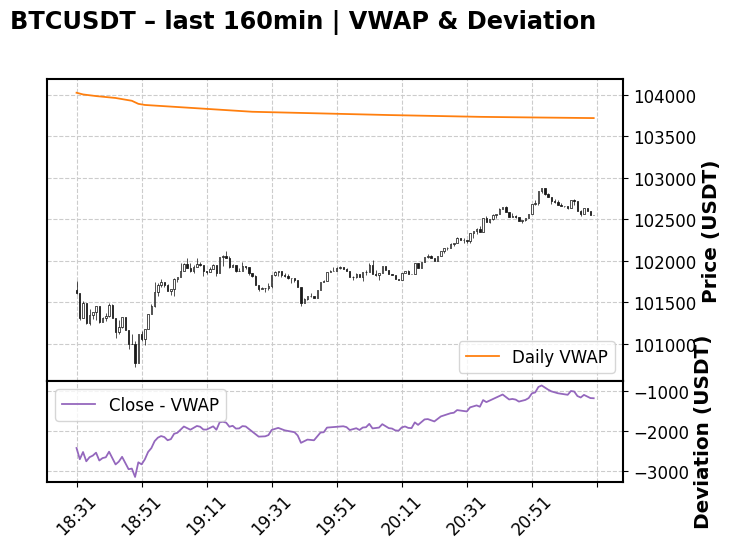

In [43]:
grp_date = df.index.date
cum_pv   = (df['Close'] * df['Volume']).groupby(grp_date).cumsum()
cum_vol  = df['Volume'].groupby(grp_date).cumsum()
df['VWAP'] = cum_pv / cum_vol

df['VWAP_Dev'] = df['Close'] - df['VWAP']

check = (df['VWAP_Dev'] * df['Volume']).groupby(grp_date).sum().abs().max()
print(f"max|Σ(vol*Dev)| per day ≈ {check:.4f}  (expect ~0)")

subset = df.last(f'{160}min').copy()

vwap_plot = mpf.make_addplot(subset['VWAP'], color='tab:orange', label='Daily VWAP')

dev_plot  = mpf.make_addplot(
    subset['VWAP_Dev'],
    panel=1, type='line', color='tab:purple',
    ylabel='Deviation (USDT)', label='Close - VWAP'
)

mpf.plot(
    subset,
    type='candle',
    addplot=[vwap_plot, dev_plot],
    panel_ratios=(3,1),
    title=f'BTCUSDT – last {160}min | VWAP & Deviation',
    style='classic',
    ylabel='Price (USDT)',
    datetime_format='%H:%M'
)